<div style="text-align: center;text-size:20px;border:1px solid red;background:blue; font-size:30px">
    <span style='background :blue; color:white' align="center"> <b>Skin Cancer Dataset</b> </span>
</div>

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

    actinic keratosis
    basal cell carcinoma
    dermatofibroma
    melanoma
    nevus
    pigmented benign keratosis
    -seborrheic keratosis
    squamous cell carcinoma
    vascular lesion

# Importing all the required libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Skin cancer ISIC The International Skin Imaging Collaboration Dataset

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path(r"/content/drive/MyDrive/upGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path(r"/content/drive/MyDrive/upGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

# Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(data_dir_train, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(type(class_names), class_names)


<class 'list'> ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize an instance of all nine classes present in the dataset

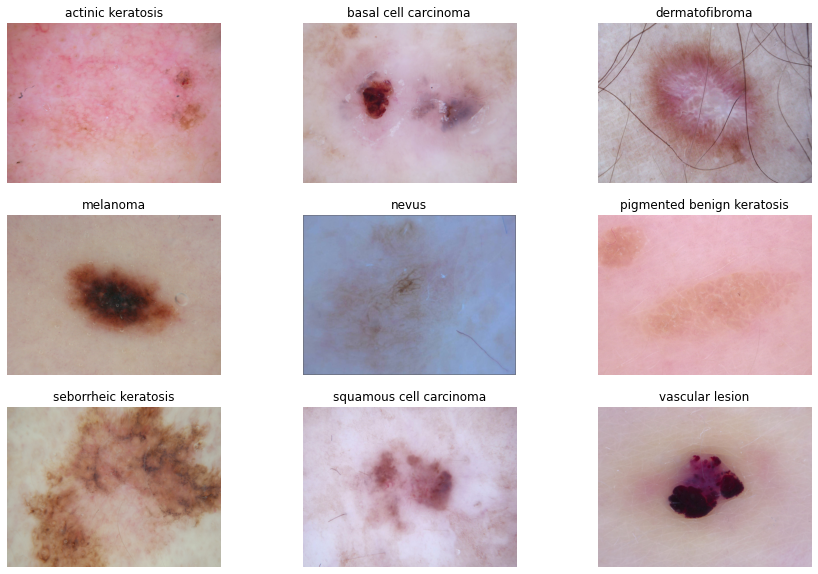

In [9]:
### training data

plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [10]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


Check the configuration of gpu and use gpu.

In [11]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
# Model - Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Flatten -> Dense -> Dense
num_classes = 9
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
## Your code goes here
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 90, 90, 32)        0         
                                                        

### Train the model

In [16]:
epochs = 20
history = model.fit(
                      train_ds,
                      validation_data = val_ds,
                      epochs=epochs
                    )

Epoch 1/20
56/56 [==============================] - 22s 82ms/step - loss: 2.0417 - accuracy: 0.2433 - val_loss: 1.7879 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.7403 - accuracy: 0.3627 - val_loss: 1.5605 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4725 - accuracy: 0.4983 - val_loss: 1.4212 - val_accuracy: 0.5213
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3230 - accuracy: 0.5402 - val_loss: 1.3778 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2230 - accuracy: 0.5776 - val_loss: 1.3295 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.1506 - accuracy: 0.5932 - val_loss: 1.4421 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.0682 - accuracy: 0.6261 - val_loss: 1.3459 - val_accuracy: 0.5615
Epoch 8/20
5

### Visualizing training results

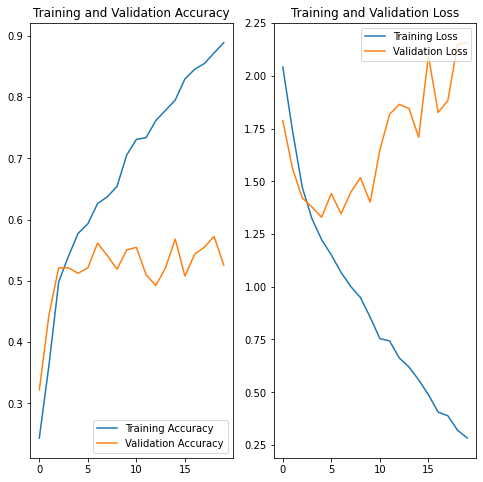

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here -

Model Inference : The model is overfitting where the traning accuracy is much higher than validation accuracy

# Using data augmentation

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

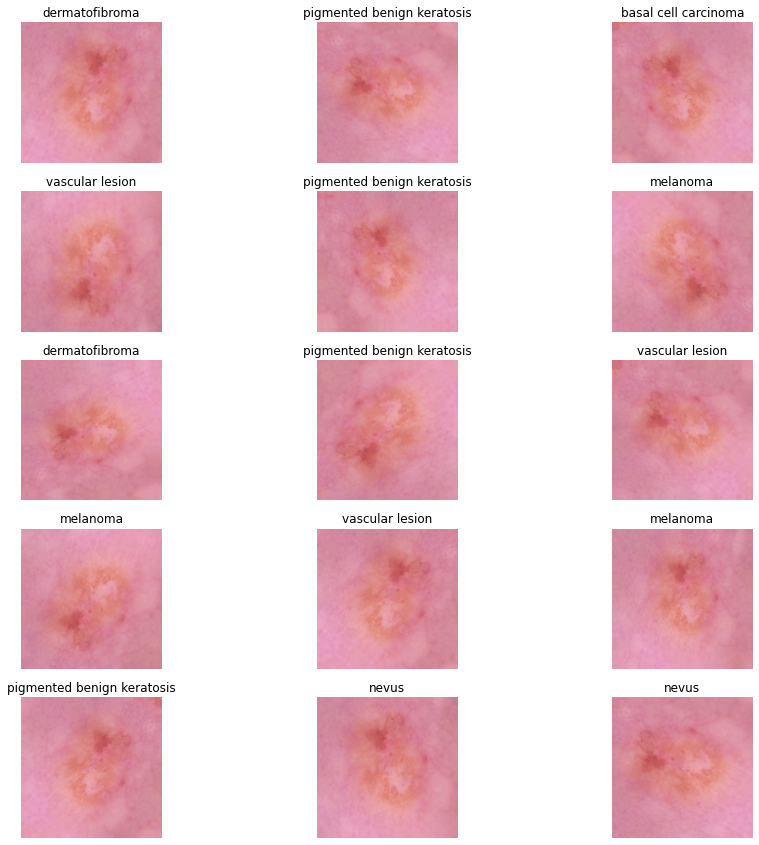

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

# Create the model, compile and train the model


```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [20]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

### Compiling the model

In [21]:
## Your code goes here
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_4 (Activation)   (None, 180, 180, 16)      0         
                                                      

### Training the model

In [23]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 52ms/step - loss: 2.0639 - accuracy: 0.2115 - val_loss: 2.0040 - val_accuracy: 0.1969
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.8122 - accuracy: 0.3482 - val_loss: 1.7483 - val_accuracy: 0.3826
Epoch 3/20
56/56 [==============================] - 3s 48ms/step - loss: 1.5539 - accuracy: 0.4554 - val_loss: 1.5237 - val_accuracy: 0.4609
Epoch 4/20
56/56 [==============================] - 3s 48ms/step - loss: 1.5035 - accuracy: 0.4704 - val_loss: 1.3996 - val_accuracy: 0.5391
Epoch 5/20
56/56 [==============================] - 3s 50ms/step - loss: 1.4411 - accuracy: 0.4944 - val_loss: 1.3758 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3671 - accuracy: 0.5134 - val_loss: 1.4142 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.3201 - accuracy: 0.5296 - val_loss: 1.3722 - val_accuracy: 0.5324
Epoch 8/20
56

# Visualizing the results

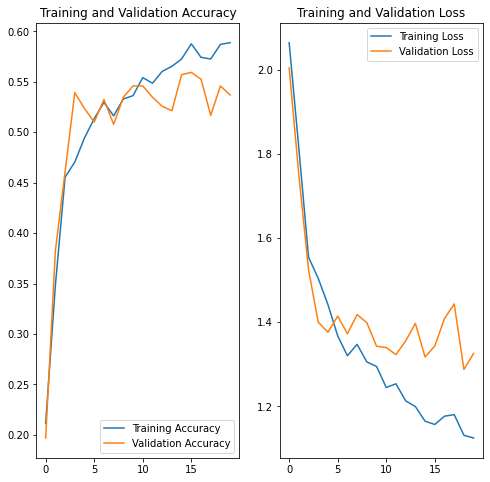

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model Inference - Comparing the Model-1 and Model-2, overfitting has been reduced with difference of 5 %

# Distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [26]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


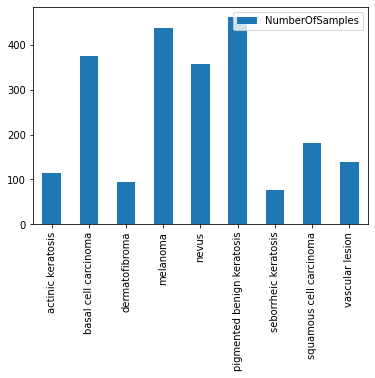

In [27]:
class_df.plot.bar()
plt.show()

#### **Todo:** Write your findings here: 

#### - Which class has the least number of samples? 
#### Answer : seborrheic keratosis has least number of samples (sample size - 77) among all classes

#### - Which classes dominate the data in terms proportionate number of samples?
#### Answer : The class that dominates the data in terms of proportionate number of samples is Pigmented Benign Keratosis (with sample size - 462)



# Rectify the class imbalance
#### Python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import Augmentor

In [30]:
path_to_training_dataset = '/content/drive/MyDrive/upGrad/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD4924A0B90>: 100%|██████████| 500/500 [00:20<00:00, 24.48 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD492484D10>: 100%|██████████| 500/500 [00:21<00:00, 23.58 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD4924F6310>: 100%|██████████| 500/500 [00:21<00:00, 23.03 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD4961ABAD0>: 100%|██████████| 500/500 [01:36<00:00,  5.16 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=2155x1958 at 0x7FD4964B5390>: 100%|██████████| 500/500 [01:31<00:00,  5.48 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD49605EA50>: 100%|██████████| 500/500 [00:17<00:00, 28.93 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/seborrheic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FD511378E50>: 100%|██████████| 500/500 [00:40<00:00, 12.26 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/squamous cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD49609BC10>: 100%|██████████| 500/500 [00:17<00:00, 29.12 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/vascular lesion/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD511242BD0>: 100%|██████████| 500/500 [00:16<00:00, 29.51 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
output_dir = pathlib.Path('/kaggle/working/')

In [32]:
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [34]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/upGrad/Skin cancer ISIC...,melanoma
1,/content/drive/MyDrive/upGrad/Skin cancer ISIC...,melanoma
2,/content/drive/MyDrive/upGrad/Skin cancer ISIC...,melanoma
3,/content/drive/MyDrive/upGrad/Skin cancer ISIC...,melanoma
4,/content/drive/MyDrive/upGrad/Skin cancer ISIC...,melanoma
...,...,...
2234,/content/drive/MyDrive/upGrad/Skin cancer ISIC...,basal cell carcinoma
2235,/content/drive/MyDrive/upGrad/Skin cancer ISIC...,basal cell carcinoma
2236,/content/drive/MyDrive/upGrad/Skin cancer ISIC...,basal cell carcinoma
2237,/content/drive/MyDrive/upGrad/Skin cancer ISIC...,basal cell carcinoma


In [35]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# Train the model on the data created using Augmentor

#### **Todo:** Create a training dataset

In [36]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13500 files belonging to 9 classes.
Using 10800 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13500 files belonging to 9 classes.
Using 2700 files for validation.


In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create your model (make sure to include normalization)

In [39]:
num_classes = 9

# Model - Rescaling -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

#### Compile your model (Choose optimizer and loss function appropriately)

In [40]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_8 (Activation)   (None, 180, 180, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 16)       

#### Train your model

In [42]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
338/338 [==============================] - 55s 56ms/step - loss: 2.2889 - accuracy: 0.3600 - val_loss: 26.4482 - val_accuracy: 0.1189
Epoch 2/30
338/338 [==============================] - 11s 34ms/step - loss: 1.2324 - accuracy: 0.5351 - val_loss: 3.6958 - val_accuracy: 0.3930
Epoch 3/30
338/338 [==============================] - 11s 33ms/step - loss: 0.9201 - accuracy: 0.6492 - val_loss: 2.3946 - val_accuracy: 0.4641
Epoch 4/30
338/338 [==============================] - 11s 33ms/step - loss: 0.7309 - accuracy: 0.7220 - val_loss: 4.1900 - val_accuracy: 0.3626
Epoch 5/30
338/338 [==============================] - 11s 32ms/step - loss: 0.6133 - accuracy: 0.7722 - val_loss: 4.4514 - val_accuracy: 0.4415
Epoch 6/30
338/338 [==============================] - 11s 32ms/step - loss: 0.5096 - accuracy: 0.8150 - val_loss: 1.8493 - val_accuracy: 0.5133
Epoch 7/30
338/338 [==============================] - 11s 32ms/step - loss: 0.4304 - accuracy: 0.8449 - val_loss: 0.7616 - val_accuracy

#### Visualize the model results

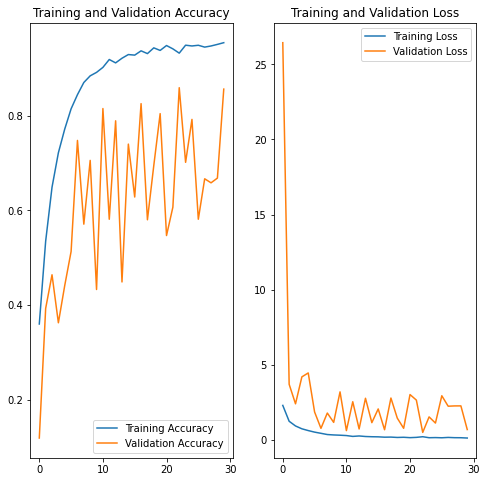

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

####  Analyzing the results!
#### Findings after the model fit, see if there is an evidence of model overfit or underfit



We still have some overfitting but we have much better accuracy than previous models. At end we have around 10% accuracy difference between training and validation data.
Adjusting Class imbalance helped us in getting better accuracy. 

We can reduce the overfitting by having a deeper model or add a data augmentation layer before it.

# Model with data augmentation and using Augmentor dataset

In [44]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [45]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense

model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [46]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_12 (Activation)  (None, 180, 180, 16)      0         
                                                      

In [48]:
epochs = 50
# Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
338/338 [==============================] - 16s 43ms/step - loss: 1.6870 - accuracy: 0.3376 - val_loss: 1.5264 - val_accuracy: 0.4170
Epoch 2/50
338/338 [==============================] - 16s 47ms/step - loss: 1.3449 - accuracy: 0.4925 - val_loss: 1.2966 - val_accuracy: 0.4874
Epoch 3/50
338/338 [==============================] - 14s 41ms/step - loss: 1.2293 - accuracy: 0.5312 - val_loss: 1.1568 - val_accuracy: 0.5715
Epoch 4/50
338/338 [==============================] - 14s 40ms/step - loss: 1.1321 - accuracy: 0.5731 - val_loss: 1.0823 - val_accuracy: 0.6115
Epoch 5/50
338/338 [==============================] - 14s 40ms/step - loss: 1.0363 - accuracy: 0.6071 - val_loss: 0.8956 - val_accuracy: 0.6800
Epoch 6/50
338/338 [==============================] - 14s 40ms/step - loss: 0.9273 - accuracy: 0.6528 - val_loss: 0.8035 - val_accuracy: 0.6981
Epoch 7/50
338/338 [==============================] - 14s 41ms/step - loss: 0.8321 - accuracy: 0.6896 - val_loss: 0.7578 - val_accuracy:

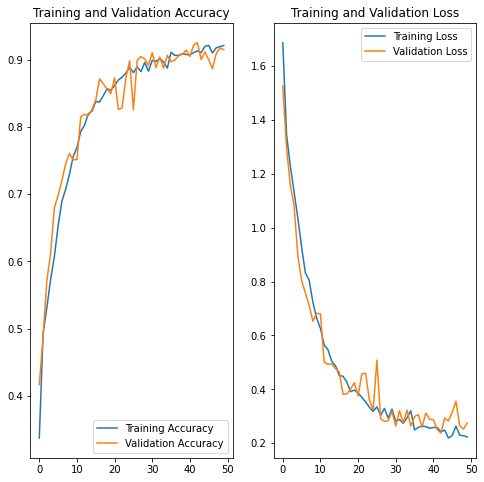

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### Model Inference :

#### When compared against previous models, model with data augmentation and using augmentor dataset has better accuracy.

# Model evaluation

In [50]:
test_dataset = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 118 files belonging to 9 classes.


Predictions:
 [1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1
 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0
 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1
 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1
 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0
 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1
 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 1]
Labels:
 [5 1 7 4 1 7 7 7 4 5 3 7 2 1 7 7 6 7 0 6 3 3 1 4 7 5 2 3 3 2 6 2]


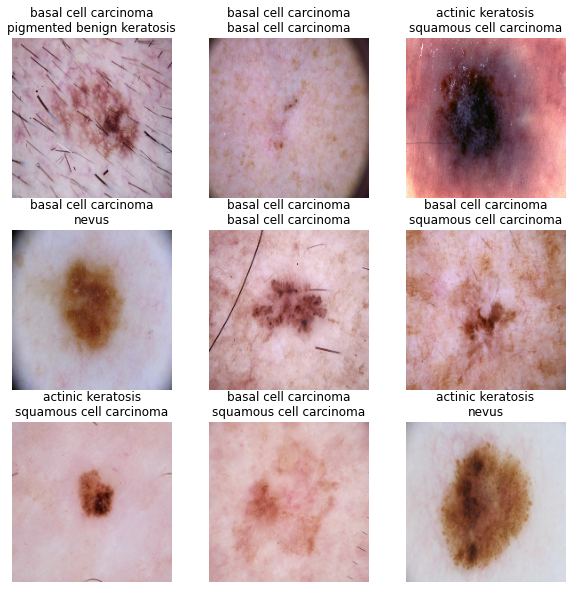

In [51]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")